In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import math
import pandas as pd
from gplearn.tests.test_genetic import *
from gplearn._program import _Program
from gplearn.genetic import _all_func_dictionary, _fitness_map
from gplearn.extra_fitness import *
import matplotlib.pyplot as plt

In [75]:
df = pd.read_parquet('/home/pennymax/proj/MFM/CrossSection/v1_basic/results/basic_2023-11-22_22:15:18/fct_man_ta_proc.parquet')
df = df.query('time > "2020-01-01 00:00:00+00:00"')
df

,,AR_26,BCKRET1_ALMA_10_6.0_0.85,BCKRET1_ANGLEd_1,BCKRET1_APO_12_26,BCKRET1_BIAS_SMA_26,BCKRET1_CFO_9,BCKRET1_CG_10,BCKRET1_CMO_14,BCKRET1_COPC_11_14_10,BCKRET1_CTI_12,...,premIdx_close,premIdx_high,premIdx_low,premIdx_open,spot_QuoVol,spot_TakerBuyQuoVol,spotum_quo_rt1,spotum_quo_rt3,spotum_quo_rt5,fwdret1
time,symbol,,,,,,,,,,,,,,,,,,,,,
2022-02-15 00:00:00+00:00,1000BTTCUSDT,0.301435,0.275936,-0.488968,0.771073,-1.161410,0.358964,-0.067306,0.607884,-0.221017,0.085637,...,0.654780,1.305227,-1.578736,0.773644,-0.286571,-0.290574,-1.698317,-1.750555,-1.797949,0.006381
2022-02-15 08:00:00+00:00,1000BTTCUSDT,0.203825,0.346633,-0.102897,0.670855,-0.063863,-0.128800,-0.200930,-0.632266,-0.184119,-0.056086,...,0.654619,1.852459,-2.511996,-3.652448,-0.281280,-0.280721,-1.825539,-1.865662,-1.797600,0.005435
2022-02-15 16:00:00+00:00,1000BTTCUSDT,0.109859,0.194290,-0.281913,-0.625057,-0.035205,-0.048292,-0.183299,-0.913829,-0.256562,-0.479517,...,0.429367,1.520373,-0.490996,0.573695,-0.311542,-0.305104,-1.896369,-1.871790,-1.849618,-0.001351
2022-02-16 00:00:00+00:00,1000BTTCUSDT,-0.026714,0.305321,0.818629,-0.432105,-0.135898,0.066802,-0.001660,0.009961,-0.201409,-0.858671,...,5.207442,2.838670,-1.876175,0.332018,-0.333334,-0.335837,-1.982989,-1.945231,-1.941199,-0.026613
2022-02-16 08:00:00+00:00,1000BTTCUSDT,-0.038897,0.149609,0.062552,-0.885780,-0.009816,-0.113658,0.227472,-0.964727,-0.254134,-0.789266,...,0.377948,2.072545,-2.015252,0.486841,-0.345787,-0.341323,-1.852673,-2.017361,-1.978387,0.007878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-19 08:00:00+00:00,ZRXUSDT,3.664874,-3.113825,-1.648899,-5.691401,-0.116280,-0.002034,0.123369,-1.341036,0.297297,-0.282686,...,-0.606585,-0.537085,-0.761102,-0.556576,-0.180849,-0.182091,2.612331,1.771783,2.564827,0.031750
2023-11-19 16:00:00+00:00,ZRXUSDT,2.537322,-2.549892,1.657452,-3.906109,0.200481,0.048510,0.013754,-0.415205,0.089457,0.273883,...,-1.876145,-1.285125,-0.262280,-0.726266,-0.179718,-0.181448,3.599520,1.947164,2.446037,-0.007005
2023-11-20 00:00:00+00:00,ZRXUSDT,2.659109,-2.900207,-0.704719,-3.857578,-3.198881,0.147065,-0.106040,-0.386359,-0.024935,0.805087,...,-1.187991,-0.596983,-0.625408,-2.571711,-0.198680,-0.209446,2.944125,3.235569,2.244819,0.010330


In [76]:
df.reset_index().sort_values('time').time.unique()

<DatetimeArray>
['2020-01-21 00:00:00+00:00', '2020-01-21 08:00:00+00:00',
 '2020-01-21 16:00:00+00:00', '2020-01-22 00:00:00+00:00',
 '2020-01-22 08:00:00+00:00', '2020-01-22 16:00:00+00:00',
 '2020-01-23 00:00:00+00:00', '2020-01-23 08:00:00+00:00',
 '2020-01-23 16:00:00+00:00', '2020-01-24 00:00:00+00:00',
 ...
 '2023-11-17 16:00:00+00:00', '2023-11-18 00:00:00+00:00',
 '2023-11-18 08:00:00+00:00', '2023-11-18 16:00:00+00:00',
 '2023-11-19 00:00:00+00:00', '2023-11-19 08:00:00+00:00',
 '2023-11-19 16:00:00+00:00', '2023-11-20 00:00:00+00:00',
 '2023-11-20 08:00:00+00:00', '2023-11-20 16:00:00+00:00']
Length: 4200, dtype: datetime64[ns, UTC]

In [77]:
def _get_X_y(df):
    df = df.sort_index()
    display(df)
    dfX = df.drop(columns=[col for col in df.columns if col.startswith('fwdret')])
    feature_names = list(dfX.columns)
    dfX = dfX.unstack()
    display(dfX)
    X = dfX.values.reshape(len(dfX), len(feature_names), -1)

    y = df[['fwdret1']].unstack().to_numpy()
    display(df[['fwdret1']].unstack())
    print(X.shape, y.shape, len(feature_names))
    return X, y, feature_names

def convert_expression_to_gp_program(expression: str, function_set: dict, feature_names: list) -> _Program:
    ## convert expression to list function obj and feature index
    tokens = re.findall(r'[\w.]+|\(|\)|,', expression)
    tokens = [t for t in tokens if t not in ['(', ')', ',']]
    # print(tokens)
    program = []
    for token in tokens:
        if token in function_set:
            program.append(function_set[token])
        elif token in feature_names:
            program.append(feature_names.index(token))
        elif token.isdigit():
            program.append(int(token))
        elif token.replace('.', '', 1).isdigit():
            program.append(float(token))
        else:
            print(f'!! unknown token found! {token}')
            return None
    # print(program)

    ## get arity dict
    arities = {}
    for function in function_set.values():
        arity = function.arity
        arities[arity] = arities.get(arity, [])
        arities[arity].append(function)

    ## construct _Program obj
    params = {
            'function_set': function_set,
            'arities': arities,
            'n_features': len(feature_names),
            'feature_names': feature_names,
            'init_depth': (2, 6),
            ## must inputs
            'init_method': 'half and half',
            'const_range': (-1.0, 1.0),
            'metric': 'mean absolute error',
            'p_point_replace': 0.05,
            'parsimony_coefficient': 0.1,
            'random_state': check_random_state(415),
            }
    gp = _Program(program=program, **params)
    return gp

In [78]:
X, y, feature_names = _get_X_y(df)

AR_26  BCKRET1_ALMA_10_6.0_0.85  \
time                      symbol                                        
2020-01-21 00:00:00+00:00 BCHUSDT  0.633961                 -1.121931   
                          BTCUSDT -1.152786                  0.324422   
                          ETHUSDT  0.518824                  0.797509   
2020-01-21 08:00:00+00:00 BCHUSDT  0.590763                 -1.141143   
                          BTCUSDT -1.154596                  0.417780   
...                                     ...                       ...   
2023-11-20 16:00:00+00:00 YGGUSDT -0.775226                 -0.889980   
                          ZECUSDT -0.853582                 -0.363642   
                          ZENUSDT -0.464960                  0.720718   
                          ZILUSDT -0.846218                  0.922539   
                          ZRXUSDT  1.615957                 -1.918622   

                                   BCKRET1_ANGLEd_1  BCKRET1_APO_12_26  \
time                      symbol                                         
2020-01-21 00:00:00+00:00 BCHUSDT         -0.380754          -1.049658   
                          BTCUSDT          1.134448           0.941558   
                          ETHUSDT         -0.753694           0.108100   
2020-01-21 08:00:00+00:00 BCHUSDT         -0.599211          -1.131911   
                          BTCUSDT         -0.555210           0.763651   
...                                             ...                ...   
2023-11-20 16:00:00+00:00 YGGUSDT          0.929694           0.259135   
                          ZECUSDT          0.136660          -0.188729   
                          ZENUSDT         -0.691563           0.551923   
                          ZILUSDT          0.896855           0.495142   
                          ZRXUSDT          0.045286          -0.903863   

                                   BCKRET1_BIAS_SMA_26  BCKRET1_CFO_9  \
time                      symbol                                        
2020-01-21 00:00:00+00:00 BCHUSDT            -0.336027       1.148468   
                          BTCUSDT            -0.788707      -0.470477   
                          ETHUSDT             1.124734      -0.677991   
2020-01-21 08:00:00+00:00 BCHUSDT            -0.953170      -0.165917   
                          BTCUSDT            -0.087862       1.072581   
...                                                ...            ...   
2023-11-20 16:00:00+00:00 YGGUSDT            -0.067558       0.545094   
                          ZECUSDT            -0.063572      -0.021144   
                          ZENUSDT            -0.064661      -0.072191   
                          ZILUSDT            -0.069007       0.075574   
                          ZRXUSDT            -0.067730       0.114878   

                                   BCKRET1_CG_10  BCKRET1_CMO_14  \
time                      symbol                                   
2020-01-21 00:00:00+00:00 BCHUSDT      -1.031085       -0.963900   
                          BTCUSDT       0.065378        1.032561   
                          ETHUSDT       0.965707       -0.068661   
2020-01-21 08:00:00+00:00 BCHUSDT       0.279296       -1.023834   
                          BTCUSDT       0.830659        0.049507   
...                                          ...             ...   
2023-11-20 16:00:00+00:00 YGGUSDT       0.071776        0.817900   
                          ZECUSDT       0.022128       -0.175453   
                          ZENUSDT      -0.011177       -0.802206   
                          ZILUSDT       0.042398        0.949421   
                          ZRXUSDT       0.040858        0.683709   

                                   BCKRET1_COPC_11_14_10  BCKRET1_CTI_12  ...  \
time                      symbol                                          ...   
2020-01-21 00:00:00+00:00 BCHUSDT              -0.761347       -1.101016  ...   
                          BTCUSDT              

AR_26                             \
symbol                    1000BTTCUSDT 1000FLOKIUSDT 1000LUNCUSDT   
time                                                                
2020-01-21 00:00:00+00:00          NaN           NaN          NaN   
2020-01-21 08:00:00+00:00          NaN           NaN          NaN   
2020-01-21 16:00:00+00:00          NaN           NaN          NaN   
2020-01-22 00:00:00+00:00          NaN           NaN          NaN   
2020-01-22 08:00:00+00:00          NaN           NaN          NaN   
...                                ...           ...          ...   
2023-11-19 08:00:00+00:00          NaN      1.209876    -0.017766   
2023-11-19 16:00:00+00:00          NaN      1.010284     0.338275   
2023-11-20 00:00:00+00:00          NaN      1.322188     0.108759   
2023-11-20 08:00:00+00:00          NaN      1.409624    -0.072293   
2023-11-20 16:00:00+00:00          NaN      1.432228    -0.051151   

                                                                           \
symbol                    1000PEPEUSDT 1000SHIBUSDT 1000XECUSDT 1INCHUSDT   
time                                                                        
2020-01-21 00:00:00+00:00          NaN          NaN         NaN       NaN   
2020-01-21 08:00:00+00:00          NaN          NaN         NaN       NaN   
2020-01-21 16:00:00+00:00          NaN          NaN         NaN       NaN   
2020-01-22 00:00:00+00:00          NaN          NaN         NaN       NaN   
2020-01-22 08:00:00+00:00          NaN          NaN         NaN       NaN   
...                                ...          ...         ...       ...   
2023-11-19 08:00:00+00:00    -0.209249    -0.177718   -0.297947 -0.717730   
2023-11-19 16:00:00+00:00    -0.115461    -1.104164   -0.161770 -0.614664   
2023-11-20 00:00:00+00:00    -0.081292    -0.822623         NaN -0.718813   
2023-11-20 08:00:00+00:00    -0.060273    -0.783898         NaN -0.808086   
2023-11-20 16:00:00+00:00    -0.320948    -0.711968         NaN -0.660667   

                                                         ... spotum_quo_rt5  \
symbol                     AAVEUSDT   ACHUSDT   ADAUSDT  ...        XTZUSDT   
time                                                     ...                  
2020-01-21 00:00:00+00:00       NaN       NaN       NaN  ...            NaN   
2020-01-21 08:00:00+00:00       NaN       NaN       NaN  ...            NaN   
2020-01-21 16:00:00+00:00       NaN       NaN       NaN  ...            NaN   
2020-01-22 00:00:00+00:00       NaN       NaN       NaN  ...            NaN   
2020-01-22 08:00:00+00:00       NaN       NaN       NaN  ...            NaN   
...                             ...       ...       ...  ...            ...   
2023-11-19 08:00:00+00:00 -0.483983 -1.118874 -0.376072  ...       1.142127   
2023-11-19 16:00:00+00:00 -0.265661 -1.035463 -0.308242  ...       1.128182   
2023-11-20 00:00:00+00:00 -0.297778 -0.914690 -0.287269  ...       1.262307   
2023-11-20 08:00:00+00:00 -0.317431 -0.633697 -0.123666  ...       1.516744   
2023-11-20 16:00:00+00:00 -0.350808 -0.555673 -0.209878  ...       1.616295   

                                                                            \
symbol                      XVGUSDT   XVSUSDT YFIIUSDT   YFIUSDT   YGGUSDT   
time                                                                         
2020-01-21 00:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-01-21 08:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-01-21 16:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-01-22 00:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-01-22 08:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
...                             ...       ...      ...       ...       ...   
2023-11-19 08:00:00+00:00 -0.385045 -0.761242      NaN  1.458027 -0.171629   
2023-11-19 16:00:00+00:00 -0.516774 -0.753067      NaN  1.743364 -0.164711   
2023-11-20 00:00:00+00

fwdret1                             \
symbol                    1000BTTCUSDT 1000FLOKIUSDT 1000LUNCUSDT   
time                                                                
2020-01-21 00:00:00+00:00          NaN           NaN          NaN   
2020-01-21 08:00:00+00:00          NaN           NaN          NaN   
2020-01-21 16:00:00+00:00          NaN           NaN          NaN   
2020-01-22 00:00:00+00:00          NaN           NaN          NaN   
2020-01-22 08:00:00+00:00          NaN           NaN          NaN   
...                                ...           ...          ...   
2023-11-19 08:00:00+00:00          NaN      0.042844     0.019783   
2023-11-19 16:00:00+00:00          NaN     -0.006086    -0.005396   
2023-11-20 00:00:00+00:00          NaN     -0.015003    -0.005812   
2023-11-20 08:00:00+00:00          NaN     -0.037302    -0.018189   
2023-11-20 16:00:00+00:00          NaN      0.000000     0.000000   

                                                                           \
symbol                    1000PEPEUSDT 1000SHIBUSDT 1000XECUSDT 1INCHUSDT   
time                                                                        
2020-01-21 00:00:00+00:00          NaN          NaN         NaN       NaN   
2020-01-21 08:00:00+00:00          NaN          NaN         NaN       NaN   
2020-01-21 16:00:00+00:00          NaN          NaN         NaN       NaN   
2020-01-22 00:00:00+00:00          NaN          NaN         NaN       NaN   
2020-01-22 08:00:00+00:00          NaN          NaN         NaN       NaN   
...                                ...          ...         ...       ...   
2023-11-19 08:00:00+00:00     0.046193     0.018771    0.022207  0.033277   
2023-11-19 16:00:00+00:00     0.010577     0.000000    0.000000 -0.009552   
2023-11-20 00:00:00+00:00    -0.009220    -0.008752         NaN -0.004133   
2023-11-20 08:00:00+00:00    -0.051727    -0.020562         NaN -0.014388   
2023-11-20 16:00:00+00:00     0.000000     0.000000         NaN  0.000000   

                                                         ...            \
symbol                     AAVEUSDT   ACHUSDT   ADAUSDT  ...   XTZUSDT   
time                                                     ...             
2020-01-21 00:00:00+00:00       NaN       NaN       NaN  ...       NaN   
2020-01-21 08:00:00+00:00       NaN       NaN       NaN  ...       NaN   
2020-01-21 16:00:00+00:00       NaN       NaN       NaN  ...       NaN   
2020-01-22 00:00:00+00:00       NaN       NaN       NaN  ...       NaN   
2020-01-22 08:00:00+00:00       NaN       NaN       NaN  ...       NaN   
...                             ...       ...       ...  ...       ...   
2023-11-19 08:00:00+00:00  0.030054  0.041865  0.018563  ...  0.018980   
2023-11-19 16:00:00+00:00  0.007977  0.002543  0.008592  ...  0.000000   
2023-11-20 00:00:00+00:00 -0.005312  0.018772  0.012390  ...  0.004657   
2023-11-20 08:00:00+00:00 -0.016022 -0.010956 -0.029577  ... -0.023175   
2023-11-20 16:00:00+00:00  0.000000  0.000000  0.000000  ...  0.000000   

                                                                            \
symbol                      XVGUSDT   XVSUSDT YFIIUSDT   YFIUSDT   YGGUSDT   
time                                                                         
2020-01-21 00:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-01-21 08:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-01-21 16:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-01-22 00:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-01-22 08:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
...                             ...       ...      ...       ...       ...   
2023-11-19 08:00:00+00:00  0.023442  0.021856      NaN -0.039369  0.058414   
2023-11-19 16:00:00+00:00 -0.013687 -0.021813      NaN  0.019586 -0.015949   
2023-11-20 00:00:00+00:00 -0.003682  0.049812      NaN -0.010437 -0.005403   
2023-11-20 0

(4200, 1116, 237) (4200, 237) 1116


In [79]:
exp = 'sub(mul(BCKRET1_MOM_5, SPOTVOLUME_TSIs_13_25_13), premIdx_close)'
exp = 'sub(SPOT_COPC_11_14_10, ts_correlation_20(SPOTTAKERBUYQUOVOL_PPOh_12_26_9, TRDCNT_TSI_13_25_13))'
exp = 'inv(rank(TZS60_spot_Close))'
exp = 'ts_mean_20(inv(inv(TZS60_spot_Close)))'
exp = 'min(NETBUYQUO1_FWMA_10, ts_min_10(TZS60_SPOT_HLC3))'
exp = 'neg(add(premIdx_close, max(TZS60_VOLUME_PPO_12_26_9, PREMCLOSE_MACDs_12_26_9)))'
exp = 'sub(min(ts_mean_10(bckret1), netbuyquo3), max(ts_min_3(QuoVol), premIdx_close))'
exp = 'netbuyquo3'
exp = 'sub(netbuyquo3, premIdx_close)'
# exp = 'sub(ts_min_10(TZS60_spot_Close), premIdx_close)'
# exp = 'min(ts_min_10(TZS60_SPOT_HLC3), J_9_3)'
# exp = 'min(NETBUYQUO1_JMA_7_0, ts_min_10(SMI_5_20_5))'
exp = 'min(NETBUYQUO5_DEMA_10, ts_min_10(TZS60_SPOT_HL2))'

print(f'ori expression: {exp}')
feature_names = df.columns.to_list()
gp = convert_expression_to_gp_program(exp, _all_func_dictionary, feature_names)
print(f'_Program print: {gp}')

y_pred = gp.execute_3D(X)
metric_func = _fitness_map['quantile35_longshort_total_return_cumprod_with_fee']
metric_val = metric_func(y, y_pred, np.ones(X.shape[0]))
print('total return(comp):', metric_val)
metric_func = _fitness_map['quantile35_longshort_total_return_cumsum_with_fee']
metric_val = metric_func(y, y_pred, np.ones(X.shape[0]))
print('total return(cumsum):', metric_val)
metric_func = _fitness_map['quantile35_longshort_cagr_cumprod_with_fee']
metric_val = metric_func(y, y_pred, np.ones(X.shape[0]))
print('cagr:', metric_val)
metric_func = _fitness_map['quantile35_longshort_sharpe_fine_cumprod_with_fee']
metric_val = metric_func(y, y_pred, np.ones(X.shape[0]))
print('sharpe fine:', metric_val)
metric_func = _fitness_map['quantile35_longshort_sharpe_simple_cumprod_with_fee']
metric_val = metric_func(y, y_pred, np.ones(X.shape[0]))
print('sharpe simple:', metric_val)
metric_func = _fitness_map['quantile35_longshort_rolling_sharpe_sharpe_with_fee']
metric_val = metric_func(y, y_pred, np.ones(X.shape[0]))
print('rolling sharpe sharpe:', metric_val)

ori expression: min(NETBUYQUO5_DEMA_10, ts_min_10(TZS60_SPOT_HL2))
_Program print: min(NETBUYQUO5_DEMA_10, ts_min_10(TZS60_SPOT_HL2))
total return(comp): 221.82191338363586
total return(cumsum): 5.994712973822875
cagr: 3.1900596730312403
sharpe fine: 4.342068137329805
sharpe simple: 2.6872660824888217
rolling sharpe sharpe: 1.934687094349338


<Axes: >

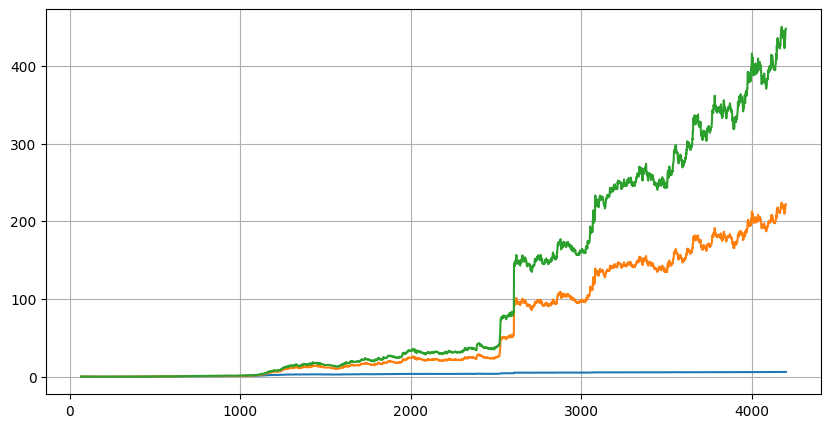

In [80]:
quantile = 35
fee_rate = 0.001
longshort_rets = quantile_longshort_returns(y, y_pred, np.ones(X.shape[0]), quantile, fee_rate)
longshort_rets.cumsum().plot()
longshort_rets.add(1).cumprod().sub(1).plot(figsize=(10, 5), grid=True)

longshort_rets_nofee = quantile_longshort_returns(y, y_pred, np.ones(X.shape[0]), quantile, 0)
longshort_rets_nofee.add(1).cumprod().sub(1).plot(figsize=(10, 5), grid=True)

,1,35,ls
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
4195,-0.019549,0.054820,0.017636
4196,0.002604,0.010317,0.006460
4197,0.002676,0.025500,0.014088
4198,0.015252,-0.013077,0.001088


,0,1,2,3,4,5,6,7,8,9,...,227,228,229,230,231,232,233,234,235,236
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,NaN,10,10,10,10,10,27,9,18,25,...,24,2,33,NaN,7,32,16,24,32,29
4196,NaN,13,13,13,7,13,30,9,19,25,...,23,2,32,NaN,2,31,17,25,30,28
4197,NaN,13,13,13,10,NaN,33,8,18,30,...,24,1,27,NaN,2,30,17,23,29,25
4198,NaN,15,15,15,12,NaN,26,8,15,29,...,22,1,28,NaN,3,29,13,22,28,23


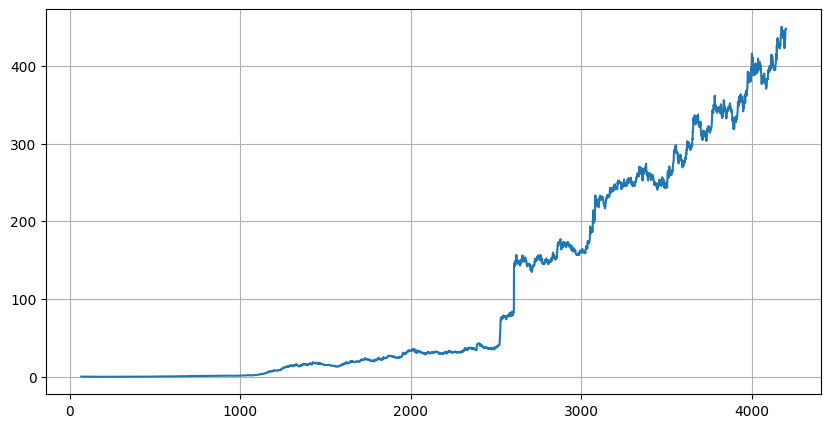

In [81]:
def compute_quantile_rets_2(y, y_pred, w, quantiles):
    y_pred = y_pred[w.astype(bool)]
    y = y[w.astype(bool)]
    if np.all(np.isnan(y_pred)):
        return None, None
    
    rets = pd.DataFrame(y)
    factor = pd.DataFrame(y_pred)

    ## use y (return) to mask y_pred to set 0 on all invaid cells to nan
    factor = factor.mask(rets.isna())
    
    groups = np.array(range(quantiles)) + 1
    
    try:
        factor_quantiles = (
            factor
            .rank(axis=1, method='first') # method first means assign different ranks on identical values
            .dropna(axis=0, how='all')
            .apply(pd.qcut, q=quantiles, labels=groups, axis=1, duplicates='drop')
            )
    except:
        return None, None
    
    stacked_rets = rets.stack()
    stacked_factor_quantiles = factor_quantiles.stack()
    grouped_returns = (
        stacked_rets
        .groupby([stacked_rets.index.get_level_values(0), stacked_factor_quantiles])
        .mean()
        .unstack()
        ) 
    return grouped_returns, factor_quantiles

grouped_returns, factor_quantiles = compute_quantile_rets_2(y, y_pred, np.ones(X.shape[0]), 35)
grouped_returns = grouped_returns[[1, 35]]
grouped_returns[1] = grouped_returns[1].mul(-1)
grouped_returns['ls'] = (grouped_returns[35] + grouped_returns[1]) / 2
display(grouped_returns)
grouped_returns.ls.add(1).cumprod().sub(1).plot(figsize=(10, 5), grid=True)
display(factor_quantiles)

(13.80622383714898, 499.4903415007561, 0.5089545014520813)

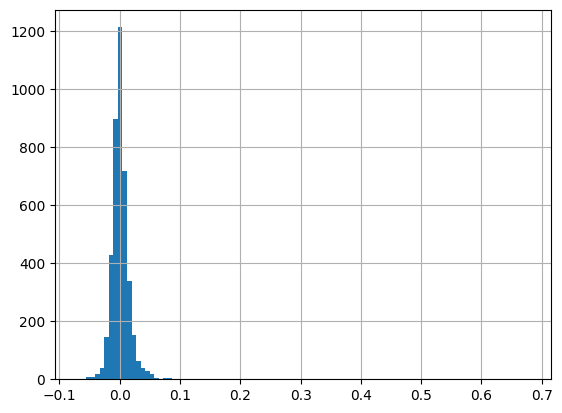

In [82]:
longshort_rets.hist(bins=100)
longshort_rets.skew(), longshort_rets.kurt(), longshort_rets[longshort_rets > 0].count() / longshort_rets.shape[0]

rolling_sharpe_sharpe: 1.9346870943493384
slope: -0.4085094921323323
radians: -0.38782055333408266
degrees: -22.220480914471185


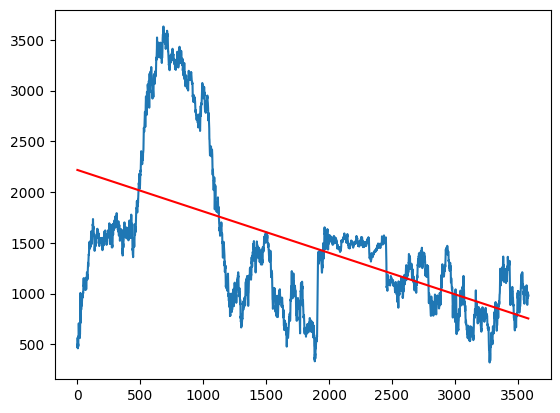

In [83]:
window = int(annual_bar_8h/2)
rolling_sharpe = longshort_rets.rolling(window).mean() / longshort_rets.rolling(window).std() * np.sqrt(annual_bar_8h) * 500
rolling_sharpe = rolling_sharpe.dropna().reset_index(drop=True)
rolling_sharpe_sharpe = rolling_sharpe.mean() / rolling_sharpe.std()
print('rolling_sharpe_sharpe:', rolling_sharpe_sharpe)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
XX = rolling_sharpe.index.values.reshape(-1, 1)
model = lr.fit(XX, rolling_sharpe.values)
slope = model.coef_[0]
angle_radians = math.atan(slope)
angle_degrees = angle_radians * 180 / math.pi
print('slope:', slope)
print('radians:', angle_radians)
print('degrees:', angle_degrees)

rolling_sharpe.plot()
y_pred2 = model.predict(XX)
plt.plot(XX, y_pred2, color='red')
plt.show()